# Sentiment Classification & How To "Frame Problems" for a Neural Network

by Andrew Trask

- **Twitter**: @iamtrask
- **Blog**: http://iamtrask.github.io

### What You Should Already Know

- neural networks, forward and back-propagation
- stochastic gradient descent
- mean squared error
- and train/test splits

### Where to Get Help if You Need it
- Re-watch previous Udacity Lectures
- Leverage the recommended Course Reading Material - [Grokking Deep Learning](https://www.manning.com/books/grokking-deep-learning) (Check inside your classroom for a discount code)
- Shoot me a tweet @iamtrask


### Tutorial Outline:

- Intro: The Importance of "Framing a Problem" (this lesson)

- [Curate a Dataset](#lesson_1)
- [Developing a "Predictive Theory"](#lesson_2)
- [**PROJECT 1**: Quick Theory Validation](#project_1)


- [Transforming Text to Numbers](#lesson_3)
- [**PROJECT 2**: Creating the Input/Output Data](#project_2)


- Putting it all together in a Neural Network (video only - nothing in notebook)
- [**PROJECT 3**: Building our Neural Network](#project_3)


- [Understanding Neural Noise](#lesson_4)
- [**PROJECT 4**: Making Learning Faster by Reducing Noise](#project_4)


- [Analyzing Inefficiencies in our Network](#lesson_5)
- [**PROJECT 5**: Making our Network Train and Run Faster](#project_5)


- [Further Noise Reduction](#lesson_6)
- [**PROJECT 6**: Reducing Noise by Strategically Reducing the Vocabulary](#project_6)


- [Analysis: What's going on in the weights?](#lesson_7)

# Lesson: Curate a Dataset<a id='lesson_1'></a>
The cells from here until Project 1 include code Andrew shows in the videos leading up to mini project 1. We've included them so you can run the code along with the videos without having to type in everything.

In [54]:
def pretty_print_review_and_label(i):
    print(labels[i] + "\t:\t" + reviews[i][:80] + "...")

g = open('reviews.txt','r') # What we know!
reviews = list(map(lambda x:x[:-1],g.readlines()))
g.close()

g = open('labels.txt','r') # What we WANT to know!
labels = list(map(lambda x:x[:-1].upper(),g.readlines()))
g.close()

**Note:** The data in `reviews.txt` we're using has already been preprocessed a bit and contains only lower case characters. If we were working from raw data, where we didn't know it was all lower case, we would want to add a step here to convert it. That's so we treat different variations of the same word, like `The`, `the`, and `THE`, all the same way.

In [55]:
len(reviews)

25000

In [56]:
reviews[0]

'bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   '

In [57]:
labels[0]

'POSITIVE'

# Lesson: Develop a Predictive Theory<a id='lesson_2'></a>

In [58]:
print("labels.txt \t : \t reviews.txt\n")
pretty_print_review_and_label(2137)
pretty_print_review_and_label(12816)
pretty_print_review_and_label(6267)
pretty_print_review_and_label(21934)
pretty_print_review_and_label(5297)
pretty_print_review_and_label(4998)

labels.txt 	 : 	 reviews.txt

NEGATIVE	:	this movie is terrible but it has some good effects .  ...
POSITIVE	:	adrian pasdar is excellent is this film . he makes a fascinating woman .  ...
NEGATIVE	:	comment this movie is impossible . is terrible  very improbable  bad interpretat...
POSITIVE	:	excellent episode movie ala pulp fiction .  days   suicides . it doesnt get more...
NEGATIVE	:	if you haven  t seen this  it  s terrible . it is pure trash . i saw this about ...
POSITIVE	:	this schiffer guy is a real genius  the movie is of excellent quality and both e...


# Project 1: Quick Theory Validation<a id='project_1'></a>

There are multiple ways to implement these projects, but in order to get your code closer to what Andrew shows in his solutions, we've provided some hints and starter code throughout this notebook.

You'll find the [Counter](https://docs.python.org/2/library/collections.html#collections.Counter) class to be useful in this exercise, as well as the [numpy](https://docs.scipy.org/doc/numpy/reference/) library.

In [59]:
from collections import Counter
import numpy as np

We'll create three `Counter` objects, one for words from postive reviews, one for words from negative reviews, and one for all the words.

In [60]:
# Create three Counter objects to store positive, negative and total counts
positive_counts = Counter()
negative_counts = Counter()
total_counts = Counter()

**TODO:** Examine all the reviews. For each word in a positive review, increase the count for that word in both your positive counter and the total words counter; likewise, for each word in a negative review, increase the count for that word in both your negative counter and the total words counter.

**Note:** Throughout these projects, you should use `split(' ')` to divide a piece of text (such as a review) into individual words. If you use `split()` instead, you'll get slightly different results than what the videos and solutions show.

In [236]:
# TODO: Loop over all the words in all the reviews and increment the counts in the appropriate counter objects
from tqdm import tqdm

for i in tqdm(range(len(labels))):
    words = reviews[i].split(' ')
    counts = Counter(words)
    if labels[i] == 'POSITIVE':
        positive_counts += counts
    else:
        negative_counts += counts

100%|██████████| 25000/25000 [02:23<00:00, 174.52it/s]


In [237]:
total_counts = positive_counts + negative_counts

Run the following two cells to list the words used in positive reviews and negative reviews, respectively, ordered from most to least commonly used. 

In [238]:
# Examine the counts of the most common words in positive reviews
positive_counts.most_common()

[('', 1100936),
 ('the', 346648),
 ('.', 319308),
 ('and', 179444),
 ('a', 167376),
 ('of', 153710),
 ('to', 133492),
 ('is', 114490),
 ('in', 100430),
 ('br', 98470),
 ('it', 96050),
 ('i', 81486),
 ('that', 71260),
 ('this', 70160),
 ('s', 67630),
 ('as', 52616),
 ('with', 46494),
 ('for', 44832),
 ('was', 43834),
 ('film', 41874),
 ('but', 41644),
 ('movie', 38148),
 ('his', 34454),
 ('on', 34016),
 ('you', 33362),
 ('he', 32564),
 ('are', 29614),
 ('not', 28544),
 ('t', 27440),
 ('one', 27310),
 ('have', 25174),
 ('be', 24832),
 ('by', 23994),
 ('all', 23884),
 ('who', 22928),
 ('an', 22588),
 ('at', 22468),
 ('from', 21534),
 ('her', 20948),
 ('they', 19790),
 ('has', 18372),
 ('so', 18308),
 ('like', 18076),
 ('about', 16626),
 ('very', 16610),
 ('out', 16268),
 ('there', 16114),
 ('she', 15558),
 ('what', 15474),
 ('or', 15464),
 ('good', 15440),
 ('more', 15042),
 ('when', 14912),
 ('some', 14882),
 ('if', 14570),
 ('just', 14304),
 ('can', 14002),
 ('story', 13560),
 ('time', 

In [239]:
# Examine the counts of the most common words in negative reviews
negative_counts.most_common()

[('', 1122924),
 ('.', 335076),
 ('the', 326778),
 ('a', 158642),
 ('and', 148770),
 ('of', 138018),
 ('to', 137948),
 ('br', 105274),
 ('is', 100166),
 ('it', 96654),
 ('i', 93760),
 ('in', 87506),
 ('this', 81840),
 ('that', 75230),
 ('s', 63092),
 ('was', 52582),
 ('movie', 49930),
 ('for', 43854),
 ('but', 43562),
 ('with', 41756),
 ('as', 41250),
 ('t', 40722),
 ('film', 38436),
 ('you', 35098),
 ('on', 34384),
 ('not', 32708),
 ('have', 30288),
 ('are', 29246),
 ('be', 29082),
 ('he', 27712),
 ('one', 26268),
 ('they', 26022),
 ('at', 24558),
 ('his', 24294),
 ('all', 24072),
 ('so', 22926),
 ('like', 22476),
 ('there', 21550),
 ('just', 21238),
 ('by', 21098),
 ('or', 20544),
 ('an', 20532),
 ('who', 19938),
 ('from', 19462),
 ('if', 19036),
 ('about', 18122),
 ('out', 17958),
 ('what', 16844),
 ('some', 16612),
 ('no', 16286),
 ('her', 15894),
 ('even', 15374),
 ('can', 15306),
 ('has', 15208),
 ('good', 14846),
 ('bad', 14802),
 ('would', 14072),
 ('up', 13940),
 ('only', 1356

As you can see, common words like "the" appear very often in both positive and negative reviews. Instead of finding the most common words in positive or negative reviews, what you really want are the words found in positive reviews more often than in negative reviews, and vice versa. To accomplish this, you'll need to calculate the **ratios** of word usage between positive and negative reviews.

**TODO:** Check all the words you've seen and calculate the ratio of postive to negative uses and store that ratio in `pos_neg_ratios`. 
>Hint: the positive-to-negative ratio for a given word can be calculated with `positive_counts[word] / float(negative_counts[word]+1)`. Notice the `+1` in the denominator – that ensures we don't divide by zero for words that are only seen in positive reviews.

In [240]:
# Create Counter object to store positive/negative ratios
pos_neg_ratios = Counter()

# TODO: Calculate the ratios of positive and negative uses of the most common words
#       Consider words to be "common" if they've been used at least 100 times
for term,cnt in list(total_counts.most_common()):
    if(cnt > 100):
        pos_neg_ratio = positive_counts[term] / float(negative_counts[term]+1)
        pos_neg_ratios[term] = pos_neg_ratio

In [241]:
total_counts

Counter({'bromwell': 16,
         'high': 4322,
         'is': 214656,
         'a': 326018,
         'cartoon': 1090,
         'comedy': 6492,
         '.': 654384,
         'it': 192704,
         'ran': 476,
         'at': 47026,
         'the': 673426,
         'same': 8106,
         'time': 25448,
         'as': 93866,
         'some': 31494,
         'other': 18326,
         'programs': 132,
         'about': 34748,
         'school': 3318,
         'life': 13256,
         '': 2223860,
         'such': 10268,
         'teachers': 154,
         'my': 25006,
         'years': 9034,
         'in': 187936,
         'teaching': 164,
         'profession': 130,
         'lead': 2620,
         'me': 21546,
         'to': 271440,
         'believe': 5010,
         'that': 146490,
         's': 130722,
         'satire': 522,
         'much': 19526,
         'closer': 412,
         'reality': 1974,
         'than': 19838,
         'scramble': 12,
         'survive': 520,
         'financia

Examine the ratios you've calculated for a few words:

In [242]:
print("Pos-to-neg ratio for 'the' = {}".format(pos_neg_ratios["the"]))
print("Pos-to-neg ratio for 'amazing' = {}".format(pos_neg_ratios["amazing"]))
print("Pos-to-neg ratio for 'terrible' = {}".format(pos_neg_ratios["terrible"]))

Pos-to-neg ratio for 'the' = 1.060802560752068
Pos-to-neg ratio for 'amazing' = 4.0304761904761905
Pos-to-neg ratio for 'terrible' = 0.17750628817822495


Looking closely at the values you just calculated, we see the following:

* Words that you would expect to see more often in positive reviews – like "amazing" – have a ratio greater than 1. The more skewed a word is toward postive, the farther from 1 its positive-to-negative ratio  will be.
* Words that you would expect to see more often in negative reviews – like "terrible" – have positive values that are less than 1. The more skewed a word is toward negative, the closer to zero its positive-to-negative ratio will be.
* Neutral words, which don't really convey any sentiment because you would expect to see them in all sorts of reviews – like "the" – have values very close to 1. A perfectly neutral word – one that was used in exactly the same number of positive reviews as negative reviews – would be almost exactly 1. The `+1` we suggested you add to the denominator slightly biases words toward negative, but it won't matter because it will be a tiny bias and later we'll be ignoring words that are too close to neutral anyway.

Ok, the ratios tell us which words are used more often in postive or negative reviews, but the specific values we've calculated are a bit difficult to work with. A very positive word like "amazing" has a value above 4, whereas a very negative word like "terrible" has a value around 0.18. Those values aren't easy to compare for a couple of reasons:

* Right now, 1 is considered neutral, but the absolute value of the postive-to-negative rations of very postive words is larger than the absolute value of the ratios for the very negative words. So there is no way to directly compare two numbers and see if one word conveys the same magnitude of positive sentiment as another word conveys negative sentiment. So we should center all the values around netural so the absolute value fro neutral of the postive-to-negative ratio for a word would indicate how much sentiment (positive or negative) that word conveys.
* When comparing absolute values it's easier to do that around zero than one. 

To fix these issues, we'll convert all of our ratios to new values using logarithms.

**TODO:** Go through all the ratios you calculated and convert them to logarithms. (i.e. use `np.log(ratio)`)

In the end, extremely positive and extremely negative words will have positive-to-negative ratios with similar magnitudes but opposite signs.

In [243]:
# TODO: Convert ratios to logs
# Convert ratios to logs
for word,ratio in pos_neg_ratios.most_common():
    pos_neg_ratios[word] = np.log(ratio)

Examine the new ratios you've calculated for the same words from before:

In [82]:
print("Pos-to-neg ratio for 'the' = {}".format(pos_neg_ratios["the"]))
print("Pos-to-neg ratio for 'amazing' = {}".format(pos_neg_ratios["amazing"]))
print("Pos-to-neg ratio for 'terrible' = {}".format(pos_neg_ratios["terrible"]))

Pos-to-neg ratio for 'the' = 0.05902269426102881
Pos-to-neg ratio for 'amazing' = 1.3919815802404802
Pos-to-neg ratio for 'terrible' = -1.7291085042663878


If everything worked, now you should see neutral words with values close to zero. In this case, "the" is near zero but slightly positive, so it was probably used in more positive reviews than negative reviews. But look at "amazing"'s ratio - it's above `1`, showing it is clearly a word with positive sentiment. And "terrible" has a similar score, but in the opposite direction, so it's below `-1`. It's now clear that both of these words are associated with specific, opposing sentiments.

Now run the following cells to see more ratios. 

The first cell displays all the words, ordered by how associated they are with postive reviews. (Your notebook will most likely truncate the output so you won't actually see *all* the words in the list.)

The second cell displays the 30 words most associated with negative reviews by reversing the order of the first list and then looking at the first 30 words. (If you want the second cell to display all the words, ordered by how associated they are with negative reviews, you could just write `reversed(pos_neg_ratios.most_common())`.)

You should continue to see values similar to the earlier ones we checked – neutral words will be close to `0`, words will get more positive as their ratios approach and go above `1`, and words will get more negative as their ratios approach and go below `-1`. That's why we decided to use the logs instead of the raw ratios.

In [83]:
# words most frequently seen in a review with a "POSITIVE" label
pos_neg_ratios.most_common()

[('edie', 4.6913478822291435),
 ('paulie', 4.0775374439057197),
 ('felix', 3.1527360223636558),
 ('polanski', 2.8233610476132043),
 ('matthau', 2.8067217286092401),
 ('victoria', 2.6810215287142909),
 ('mildred', 2.6026896854443837),
 ('gandhi', 2.5389738710582761),
 ('flawless', 2.451005098112319),
 ('superbly', 2.2600254785752498),
 ('perfection', 2.1594842493533721),
 ('astaire', 2.1400661634962708),
 ('captures', 2.0386195471595809),
 ('voight', 2.0301704926730531),
 ('wonderfully', 2.0218960560332353),
 ('powell', 1.9783454248084671),
 ('brosnan', 1.9547990964725592),
 ('lily', 1.9203768470501485),
 ('bakshi', 1.9029851043382795),
 ('lincoln', 1.9014583864844796),
 ('refreshing', 1.8551812956655511),
 ('breathtaking', 1.8481124057791867),
 ('bourne', 1.8478489358790986),
 ('lemmon', 1.8458266904983307),
 ('delightful', 1.8002701588959635),
 ('flynn', 1.7996646487351682),
 ('andrews', 1.7764919970972666),
 ('homer', 1.7692866133759964),
 ('beautifully', 1.7626953362841438),
 ('socc

In [84]:
# words most frequently seen in a review with a "NEGATIVE" label
list(reversed(pos_neg_ratios.most_common()))[0:30]

# Note: Above is the code Andrew uses in his solution video, 
#       so we've included it here to avoid confusion.
#       If you explore the documentation for the Counter class, 
#       you will see you could also find the 30 least common
#       words like this: pos_neg_ratios.most_common()[:-31:-1]

[('boll', -4.9698132995760007),
 ('uwe', -4.6249728132842707),
 ('seagal', -3.6441435602725449),
 ('unwatchable', -3.2580965380214821),
 ('stinker', -3.2088254890146994),
 ('mst', -2.9502698994772336),
 ('incoherent', -2.9368917735310576),
 ('unfunny', -2.6922395950755678),
 ('waste', -2.6193845640165536),
 ('blah', -2.5704288232261625),
 ('horrid', -2.4849066497880004),
 ('pointless', -2.4553061800117097),
 ('atrocious', -2.4259083090260445),
 ('redeeming', -2.3682390632154826),
 ('prom', -2.3608540011180215),
 ('drivel', -2.3470368555648795),
 ('lousy', -2.3075726345050849),
 ('worst', -2.2869878961803778),
 ('laughable', -2.2643638801738479),
 ('awful', -2.2271942470274348),
 ('poorly', -2.2207550747464135),
 ('wasting', -2.2046046846338418),
 ('remotely', -2.1972245773362196),
 ('existent', -2.0794415416798357),
 ('boredom', -1.9951003932460849),
 ('miserably', -1.9924301646902063),
 ('sucks', -1.9870682215488209),
 ('uninspired', -1.9832976811269336),
 ('lame', -1.981767458946166)

# End of Project 1. 
## Watch the next video to see Andrew's solution, then continue on to the next lesson.

# Transforming Text into Numbers<a id='lesson_3'></a>
The cells here include code Andrew shows in the next video. We've included it so you can run the code along with the video without having to type in everything.

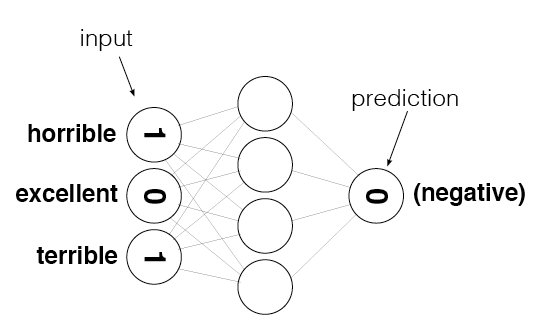

In [85]:
from IPython.display import Image

review = "This was a horrible, terrible movie."

Image(filename='sentiment_network.png')

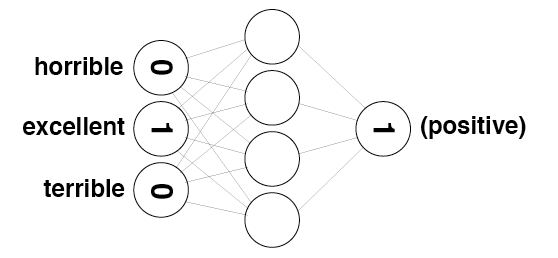

In [86]:
review = "The movie was excellent"

Image(filename='sentiment_network_pos.png')

# Project 2: Creating the Input/Output Data<a id='project_2'></a>

**TODO:** Create a [set](https://docs.python.org/3/tutorial/datastructures.html#sets) named `vocab` that contains every word in the vocabulary.

In [94]:
# TODO: Create set named "vocab" containing all of the words from all of the reviews
vocab = set(total_counts.keys())

Run the following cell to check your vocabulary size. If everything worked correctly, it should print **74074**

In [95]:
vocab_size = len(vocab)
print(vocab_size)

74074


Take a look at the following image. It represents the layers of the neural network you'll be building throughout this notebook. `layer_0` is the input layer, `layer_1` is a hidden layer, and `layer_2` is the output layer.

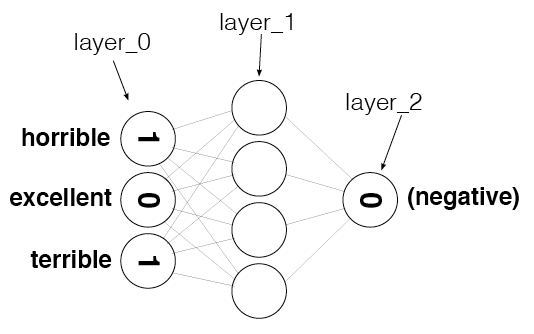

In [96]:
from IPython.display import Image
Image(filename='sentiment_network_2.png')

**TODO:** Create a numpy array called `layer_0` and initialize it to all zeros. You will find the [zeros](https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros.html) function particularly helpful here. Be sure you create `layer_0` as a 2-dimensional matrix with 1 row and `vocab_size` columns. 

In [97]:
# TODO: Create layer_0 matrix with dimensions 1 by vocab_size, initially filled with zeros
layer_0 = np.zeros((1, vocab_size))

Run the following cell. It should display `(1, 74074)`

In [99]:
layer_0.shape

(1, 74074)

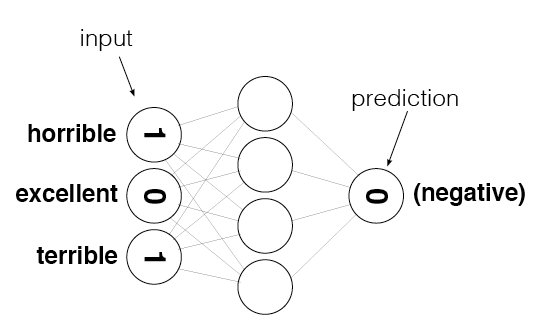

In [100]:
from IPython.display import Image
Image(filename='sentiment_network.png')

`layer_0` contains one entry for every word in the vocabulary, as shown in the above image. We need to make sure we know the index of each word, so run the following cell to create a lookup table that stores the index of every word.

In [101]:
# Create a dictionary of words in the vocabulary mapped to index positions
# (to be used in layer_0)
word2index = {}
for i,word in enumerate(vocab):
    word2index[word] = i
    
# display the map of words to indices
word2index

{'': 0,
 'plagiarized': 1,
 'studying': 2,
 'carbines': 3,
 'advancing': 4,
 'stooge': 5,
 'exoskeleton': 6,
 'loncraine': 7,
 'drumming': 8,
 'anita': 9,
 'affinities': 10,
 'dishwashers': 11,
 'dearz': 12,
 'reenactment': 13,
 'smelt': 14,
 'terrence': 15,
 'then': 16,
 'pocketing': 17,
 'surgery': 18,
 'grabbin': 19,
 'nicks': 20,
 'farmers': 21,
 'supspense': 22,
 'moustache': 23,
 'adapted': 24,
 'hidalgo': 25,
 'declines': 26,
 'pena': 27,
 'jarryd': 28,
 'locally': 29,
 'mundanity': 30,
 'stampeding': 31,
 'hah': 32,
 'caterwauling': 33,
 'gameboy': 34,
 'compel': 35,
 'corral': 36,
 'sao': 37,
 'childrens': 38,
 'scares': 39,
 'envoy': 40,
 'team': 41,
 'heir': 42,
 'shauvians': 43,
 'premiers': 44,
 'keen': 45,
 'benjy': 46,
 'lowish': 47,
 'fillet': 48,
 'poliwrath': 49,
 'administrative': 50,
 'filmstock': 51,
 'pruneface': 52,
 'cullum': 53,
 'portastatic': 54,
 'fkg': 55,
 'rattles': 56,
 'maar': 57,
 'intrigiung': 58,
 'thrill': 59,
 'everybody': 60,
 'subiaco': 61,
 'ima

**TODO:**  Complete the implementation of `update_input_layer`. It should count 
          how many times each word is used in the given review, and then store
          those counts at the appropriate indices inside `layer_0`.

In [103]:
def update_input_layer(review):
    """ Modify the global layer_0 to represent the vector form of review.
    The element at a given index of layer_0 should represent
    how many times the given word occurs in the review.
    Args:
        review(string) - the string of the review
    Returns:
        None
    """
    global layer_0
    # clear out previous state by resetting the layer to be all 0s
    layer_0 *= 0
    
    # TODO: count how many times each word is used in the given review and store the results in layer_0
    word_counter = Counter(review.split(' '))
    for word in word_counter.keys():
        layer_0[0][word2index[word]] = word_counter[word]

Run the following cell to test updating the input layer with the first review. The indices assigned may not be the same as in the solution, but hopefully you'll see some non-zero values in `layer_0`.  

In [104]:
update_input_layer(reviews[0])
layer_0

array([[ 18.,   0.,   0., ...,   0.,   0.,   0.]])

**TODO:** Complete the implementation of `get_target_for_labels`. It should return `0` or `1`, 
          depending on whether the given label is `NEGATIVE` or `POSITIVE`, respectively.

In [108]:
def get_target_for_label(label):
    """Convert a label to `0` or `1`.
    Args:
        label(string) - Either "POSITIVE" or "NEGATIVE".
    Returns:
        `0` or `1`.
    """
    # TODO: Your code here
    return 1 if (label == 'POSITIVE') else 0

Run the following two cells. They should print out`'POSITIVE'` and `1`, respectively.

In [109]:
labels[0]

'POSITIVE'

In [110]:
get_target_for_label(labels[0])

1

Run the following two cells. They should print out `'NEGATIVE'` and `0`, respectively.

In [111]:
labels[1]

'NEGATIVE'

In [112]:
get_target_for_label(labels[1])

0

# End of Project 2. 
## Watch the next video to see Andrew's solution, then continue on to the next lesson.

# Project 3: Building a Neural Network<a id='project_3'></a>

**TODO:** We've included the framework of a class called `SentimentNetork`. Implement all of the items marked `TODO` in the code. These include doing the following:
- Create a basic neural network much like the networks you've seen in earlier lessons and in Project 1, with an input layer, a hidden layer, and an output layer. 
- Do **not** add a non-linearity in the hidden layer. That is, do not use an activation function when calculating the hidden layer outputs.
- Re-use the code from earlier in this notebook to create the training data (see `TODO`s in the code)
- Implement the `pre_process_data` function to create the vocabulary for our training data generating functions
- Ensure `train` trains over the entire corpus

### Where to Get Help if You Need it
- Re-watch earlier Udacity lectures
- Chapters 3-5 - [Grokking Deep Learning](https://www.manning.com/books/grokking-deep-learning) - (Check inside your classroom for a discount code)

In [185]:
import time
import sys
import numpy as np

# Encapsulate our neural network in a class
class SentimentNetwork:
    def __init__(self, reviews, labels, hidden_nodes = 10, learning_rate = 0.1):
        """Create a SentimenNetwork with the given settings
        Args:
            reviews(list) - List of reviews used for training
            labels(list) - List of POSITIVE/NEGATIVE labels associated with the given reviews
            hidden_nodes(int) - Number of nodes to create in the hidden layer
            learning_rate(float) - Learning rate to use while training
        
        """
        # Assign a seed to our random number generator to ensure we get
        # reproducable results during development 
        np.random.seed(1)

        # process the reviews and their associated labels so that everything
        # is ready for training
        self.pre_process_data(reviews, labels)
        
        # Build the network to have the number of hidden nodes and the learning rate that
        # were passed into this initializer. Make the same number of input nodes as
        # there are vocabulary words and create a single output node.
        self.init_network(len(self.review_vocab),hidden_nodes, 1, learning_rate)

    def pre_process_data(self, reviews, labels):
        
        review_vocab = set()
        # TODO: populate review_vocab with all of the words in the given reviews
        #       Remember to split reviews into individual words 
        #       using "split(' ')" instead of "split()".
        for review in tqdm(reviews):
            review_vocab = review_vocab.union(set(review.split(' ')))
        
        # Convert the vocabulary set to a list so we can access words via indices
        self.review_vocab = list(review_vocab)
        
        label_vocab = set()
        # TODO: populate label_vocab with all of the words in the given labels.
        #       There is no need to split the labels because each one is a single word.
        label_vocab = label_vocab.union(set(labels))
        
        # Convert the label vocabulary set to a list so we can access labels via indices
        self.label_vocab = list(label_vocab)
        
        # Store the sizes of the review and label vocabularies.
        self.review_vocab_size = len(self.review_vocab)
        self.label_vocab_size = len(self.label_vocab)
        
        # Create a dictionary of words in the vocabulary mapped to index positions
        self.word2index = {}
        # TODO: populate self.word2index with indices for all the words in self.review_vocab
        #       like you saw earlier in the notebook
        for i, word in enumerate(self.review_vocab):
            self.word2index[word] = i
        
        # Create a dictionary of labels mapped to index positions
        self.label2index = {}
        # TODO: do the same thing you did for self.word2index and self.review_vocab, 
        #       but for self.label2index and self.label_vocab instead
        for i, label in enumerate(self.label_vocab):
            self.label2index[label] = i
        
    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Store the number of nodes in input, hidden, and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Store the learning rate
        self.learning_rate = learning_rate

        # Initialize weights
        
        # TODO: initialize self.weights_0_1 as a matrix of zeros. These are the weights between
        #       the input layer and the hidden layer.
        self.weights_0_1 = np.zeros((self.input_nodes, self.hidden_nodes))
        
        # TODO: initialize self.weights_1_2 as a matrix of random values. 
        #       These are the weights between the hidden layer and the output layer.
        self.weights_1_2 = np.random.normal(0.0, self.output_nodes**-0.5,
                                            (self.hidden_nodes, self.output_nodes))
        
        # TODO: Create the input layer, a two-dimensional matrix with shape 
        #       1 x input_nodes, with all values initialized to zero
        self.layer_0 = np.zeros((1,input_nodes))
    
        
    def update_input_layer(self,review):
        # TODO: You can copy most of the code you wrote for update_input_layer 
        #       earlier in this notebook. 
        #
        #       However, MAKE SURE YOU CHANGE ALL VARIABLES TO REFERENCE
        #       THE VERSIONS STORED IN THIS OBJECT, NOT THE GLOBAL OBJECTS.
        #       For example, replace "layer_0 *= 0" with "self.layer_0 *= 0"
        # clear out previous state by resetting the layer to be all 0s
        self.layer_0 *= 0
    
        # TODO: count how many times each word is used in the given review and store the results in layer_0
        for word in review.split(" "):
            # NOTE: This if-check was not in the version of this method created in Project 2,
            #       and it appears in Andrew's Project 3 solution without explanation. 
            #       It simply ensures the word is actually a key in word2index before
            #       accessing it, which is important because accessing an invalid key
            #       with raise an exception in Python. This allows us to ignore unknown
            #       words encountered in new reviews.
            if(word in self.word2index.keys()):
                self.layer_0[0][self.word2index[word]] += 1
                
    def get_target_for_label(self,label):
        # TODO: Copy the code you wrote for get_target_for_label 
        #       earlier in this notebook. 
        return 1 if (label == 'POSITIVE') else 0
        
    def sigmoid(self,x):
        # TODO: Return the result of calculating the sigmoid activation function
        #       shown in the lectures
        return 1/(1 + np.exp(-x))
    
    def sigmoid_output_2_derivative(self,output):
        # TODO: Return the derivative of the sigmoid activation function, 
        #       where "output" is the original output from the sigmoid fucntion 
        return output * (1 - output) 

    def train(self, training_reviews, training_labels):
        
        # make sure out we have a matching number of reviews and labels
        assert(len(training_reviews) == len(training_labels))
        
        # Keep track of correct predictions to display accuracy during training 
        correct_so_far = 0
        
        # Remember when we started for printing time statistics
        start = time.time()

        # loop through all the given reviews and run a forward and backward pass,
        # updating weights for every item
        for i in range(len(training_reviews)):
            
            # TODO: Get the next review and its correct label
            review = training_reviews[i]
            label = training_labels[i]
            
            # TODO: Implement the forward pass through the network. 
            #       That means use the given review to update the input layer, 
            #       then calculate values for the hidden layer,
            #       and finally calculate the output layer.
            # 
            #       Do not use an activation function for the hidden layer,
            #       but use the sigmoid activation function for the output layer.
            # Input Layer
            self.update_input_layer(review)
            
            # Hidden layer
            layer_1 = self.layer_0.dot(self.weights_0_1)

            # Output layer
            layer_2 = self.sigmoid(layer_1.dot(self.weights_1_2))            
            
            # TODO: Implement the back propagation pass here. 
            #       That means calculate the error for the forward pass's prediction
            #       and update the weights in the network according to their
            #       contributions toward the error, as calculated via the
            #       gradient descent and back propagation algorithms you 
            #       learned in class.
            # Output error
            layer_2_error = layer_2 - self.get_target_for_label(label) # Output layer error is the difference between desired target and actual output.
            layer_2_delta = layer_2_error * self.sigmoid_output_2_derivative(layer_2)
            
            # Backpropagated error
            layer_1_error = layer_2_delta.dot(self.weights_1_2.T) # errors propagated to the hidden layer
            layer_1_delta = layer_1_error # hidden layer gradients - no nonlinearity so it's the same as the error

            # Update the weights
            self.weights_1_2 -= self.layer_1.T.dot(layer_2_delta) * self.learning_rate # update hidden-to-output weights with gradient descent step
            
            # TODO: Keep track of correct predictions. To determine if the prediction was
            #       correct, check that the absolute value of the output error 
            #       is less than 0.5. If so, add one to the correct_so_far count.
            if(layer_2 >= 0.5 and label == 'POSITIVE'):
                correct_so_far += 1
            elif(layer_2 < 0.5 and label == 'NEGATIVE'):
                correct_so_far += 1
            
            # For debug purposes, print out our prediction accuracy and speed 
            # throughout the training process. 

            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct_so_far) + " #Trained:" + str(i+1) \
                             + " Training Accuracy:" + str(correct_so_far * 100 / float(i+1))[:4] + "%")
            if(i % 2500 == 0):
                print("")
    
    def test(self, testing_reviews, testing_labels):
        """
        Attempts to predict the labels for the given testing_reviews,
        and uses the test_labels to calculate the accuracy of those predictions.
        """
        
        # keep track of how many correct predictions we make
        correct = 0

        # we'll time how many predictions per second we make
        start = time.time()

        # Loop through each of the given reviews and call run to predict
        # its label. 
        for i in range(len(testing_reviews)):
            pred = self.run(testing_reviews[i])
            if(pred == testing_labels[i]):
                correct += 1
            
            # For debug purposes, print out our prediction accuracy and speed 
            # throughout the prediction process. 

            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(testing_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct) + " #Tested:" + str(i+1) \
                             + " Testing Accuracy:" + str(correct * 100 / float(i+1))[:4] + "%")
    
    def run(self, review):
        """
        Returns a POSITIVE or NEGATIVE prediction for the given review.
        """
        # TODO: Run a forward pass through the network, like you did in the
        #       "train" function. That means use the given review to 
        #       update the input layer, then calculate values for the hidden layer,
        #       and finally calculate the output layer.
        #
        #       Note: The review passed into this function for prediction 
        #             might come from anywhere, so you should convert it 
        #             to lower case prior to using it.
        # Input Layer
        self.update_input_layer(review.lower())
        
        # Hidden layer
        layer_1 = self.layer_0.dot(self.weights_0_1)
        
        # Output layer
        layer_2 = self.sigmoid(layer_1.dot(self.weights_1_2))
        
        # TODO: The output layer should now contain a prediction. 
        #       Return `POSITIVE` for predictions greater-than-or-equal-to `0.5`, 
        #       and `NEGATIVE` otherwise.
        if(layer_2[0] >= 0.5):
            return "POSITIVE"
        else:
            return "NEGATIVE"


Run the following cell to create a `SentimentNetwork` that will train on all but the last 1000 reviews (we're saving those for testing). Here we use a learning rate of `0.1`.

In [186]:
mlp = SentimentNetwork(reviews[:-1000],labels[:-1000], learning_rate=0.1)

100%|██████████| 24000/24000 [02:27<00:00, 162.89it/s]


Run the following cell to test the network's performance against the last 1000 reviews (the ones we held out from our training set). 

**We have not trained the model yet, so the results should be about 50% as it will just be guessing and there are only two possible values to choose from.**

In [187]:
mlp.test(reviews[-1000:],labels[-1000:])

Progress:99.9% Speed(reviews/sec):259.3 #Correct:500 #Tested:1000 Testing Accuracy:50.0%

Run the following cell to actually train the network. During training, it will display the model's accuracy repeatedly as it trains so you can see how well it's doing.

In [188]:
mlp.train(reviews[:-1000],labels[:-1000])

AttributeError: 'SentimentNetwork' object has no attribute 'layer_1'

That most likely didn't train very well. Part of the reason may be because the learning rate is too high. Run the following cell to recreate the network with a smaller learning rate, `0.01`, and then train the new network.

In [132]:
mlp = SentimentNetwork(reviews[:-1000],labels[:-1000], learning_rate=0.01)
mlp.train(reviews[:-1000],labels[:-1000])

Progress:0.0% Speed(reviews/sec):0.0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):99.46 #Correct:1248 #Trained:2501 Training Accuracy:49.9%
Progress:20.8% Speed(reviews/sec):101.5 #Correct:2498 #Trained:5001 Training Accuracy:49.9%
Progress:31.2% Speed(reviews/sec):103.4 #Correct:3748 #Trained:7501 Training Accuracy:49.9%
Progress:41.6% Speed(reviews/sec):102.4 #Correct:4998 #Trained:10001 Training Accuracy:49.9%
Progress:52.0% Speed(reviews/sec):97.40 #Correct:6248 #Trained:12501 Training Accuracy:49.9%
Progress:62.5% Speed(reviews/sec):96.01 #Correct:7494 #Trained:15001 Training Accuracy:49.9%
Progress:72.9% Speed(reviews/sec):91.88 #Correct:8752 #Trained:17501 Training Accuracy:50.0%
Progress:83.3% Speed(reviews/sec):91.61 #Correct:10002 #Trained:20001 Training Accuracy:50.0%
Progress:93.7% Speed(reviews/sec):90.89 #Correct:11252 #Trained:22501 Training Accuracy:50.0%
Progress:99.9% Speed(reviews/sec):90.45 #Correct:12001 #Trained:24000 Training Ac

That probably wasn't much different. Run the following cell to recreate the network one more time with an even smaller learning rate, `0.001`, and then train the new network.

In [133]:
mlp = SentimentNetwork(reviews[:-1000],labels[:-1000], learning_rate=0.001)
mlp.train(reviews[:-1000],labels[:-1000])

Progress:0.0% Speed(reviews/sec):0.0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):100.2 #Correct:1273 #Trained:2501 Training Accuracy:50.8%
Progress:20.8% Speed(reviews/sec):101.9 #Correct:2649 #Trained:5001 Training Accuracy:52.9%
Progress:31.2% Speed(reviews/sec):106.4 #Correct:4140 #Trained:7501 Training Accuracy:55.1%
Progress:41.6% Speed(reviews/sec):110.1 #Correct:5693 #Trained:10001 Training Accuracy:56.9%
Progress:52.0% Speed(reviews/sec):111.9 #Correct:7266 #Trained:12501 Training Accuracy:58.1%
Progress:62.5% Speed(reviews/sec):113.2 #Correct:8888 #Trained:15001 Training Accuracy:59.2%
Progress:72.9% Speed(reviews/sec):114.2 #Correct:10503 #Trained:17501 Training Accuracy:60.0%
Progress:83.3% Speed(reviews/sec):114.8 #Correct:12190 #Trained:20001 Training Accuracy:60.9%
Progress:93.7% Speed(reviews/sec):115.5 #Correct:13925 #Trained:22501 Training Accuracy:61.8%
Progress:99.9% Speed(reviews/sec):115.8 #Correct:14983 #Trained:24000 Training A

With a learning rate of `0.001`, the network should finall have started to improve during training. It's still not very good, but it shows that this solution has potential. We will improve it in the next lesson.

# End of Project 3. 
## Watch the next video to see Andrew's solution, then continue on to the next lesson.

# Understanding Neural Noise<a id='lesson_4'></a>

The following cells include includes the code Andrew shows in the next video. We've included it here so you can run the cells along with the video without having to type in everything.

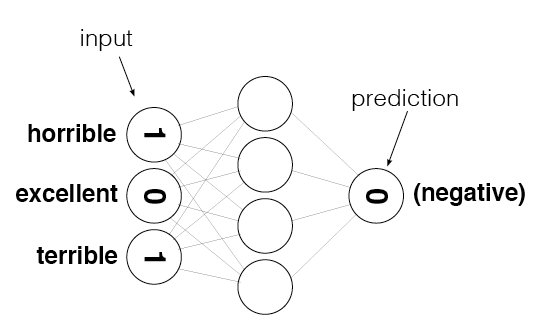

In [134]:
from IPython.display import Image
Image(filename='sentiment_network.png')

In [135]:
def update_input_layer(review):
    
    global layer_0
    
    # clear out previous state, reset the layer to be all 0s
    layer_0 *= 0
    for word in review.split(" "):
        layer_0[0][word2index[word]] += 1

update_input_layer(reviews[0])

In [136]:
layer_0

array([[ 18.,   0.,   0., ...,   0.,   0.,   0.]])

In [137]:
review_counter = Counter()

In [138]:
for word in reviews[0].split(" "):
    review_counter[word] += 1

In [139]:
review_counter.most_common()

[('.', 27),
 ('', 18),
 ('the', 9),
 ('to', 6),
 ('high', 5),
 ('i', 5),
 ('bromwell', 4),
 ('is', 4),
 ('a', 4),
 ('teachers', 4),
 ('that', 4),
 ('of', 4),
 ('it', 2),
 ('at', 2),
 ('as', 2),
 ('school', 2),
 ('my', 2),
 ('in', 2),
 ('me', 2),
 ('students', 2),
 ('their', 2),
 ('student', 2),
 ('cartoon', 1),
 ('comedy', 1),
 ('ran', 1),
 ('same', 1),
 ('time', 1),
 ('some', 1),
 ('other', 1),
 ('programs', 1),
 ('about', 1),
 ('life', 1),
 ('such', 1),
 ('years', 1),
 ('teaching', 1),
 ('profession', 1),
 ('lead', 1),
 ('believe', 1),
 ('s', 1),
 ('satire', 1),
 ('much', 1),
 ('closer', 1),
 ('reality', 1),
 ('than', 1),
 ('scramble', 1),
 ('survive', 1),
 ('financially', 1),
 ('insightful', 1),
 ('who', 1),
 ('can', 1),
 ('see', 1),
 ('right', 1),
 ('through', 1),
 ('pathetic', 1),
 ('pomp', 1),
 ('pettiness', 1),
 ('whole', 1),
 ('situation', 1),
 ('all', 1),
 ('remind', 1),
 ('schools', 1),
 ('knew', 1),
 ('and', 1),
 ('when', 1),
 ('saw', 1),
 ('episode', 1),
 ('which', 1),
 ('r

# Project 4: Reducing Noise in Our Input Data<a id='project_4'></a>

**TODO:** Attempt to reduce the noise in the input data like Andrew did in the previous video. Specifically, do the following:
* Copy the `SentimentNetwork` class you created earlier into the following cell.
* Modify `update_input_layer` so it does not count how many times each word is used, but rather just stores whether or not a word was used. 

In [140]:
import time
import sys
import numpy as np

# Encapsulate our neural network in a class
class SentimentNetwork:
    def __init__(self, reviews, labels, hidden_nodes = 10, learning_rate = 0.1):
        """Create a SentimenNetwork with the given settings
        Args:
            reviews(list) - List of reviews used for training
            labels(list) - List of POSITIVE/NEGATIVE labels associated with the given reviews
            hidden_nodes(int) - Number of nodes to create in the hidden layer
            learning_rate(float) - Learning rate to use while training
        
        """
        # Assign a seed to our random number generator to ensure we get
        # reproducable results during development 
        np.random.seed(1)

        # process the reviews and their associated labels so that everything
        # is ready for training
        self.pre_process_data(reviews, labels)
        
        # Build the network to have the number of hidden nodes and the learning rate that
        # were passed into this initializer. Make the same number of input nodes as
        # there are vocabulary words and create a single output node.
        self.init_network(len(self.review_vocab),hidden_nodes, 1, learning_rate)

    def pre_process_data(self, reviews, labels):
        
        review_vocab = set()
        # TODO: populate review_vocab with all of the words in the given reviews
        #       Remember to split reviews into individual words 
        #       using "split(' ')" instead of "split()".
        for review in reviews:
            review_vocab = review_vocab.union(set(review.split(' ')))
        
        # Convert the vocabulary set to a list so we can access words via indices
        self.review_vocab = list(review_vocab)
        
        label_vocab = set()
        # TODO: populate label_vocab with all of the words in the given labels.
        #       There is no need to split the labels because each one is a single word.
        label_vocab = label_vocab.union(set(labels))
        
        # Convert the label vocabulary set to a list so we can access labels via indices
        self.label_vocab = list(label_vocab)
        
        # Store the sizes of the review and label vocabularies.
        self.review_vocab_size = len(self.review_vocab)
        self.label_vocab_size = len(self.label_vocab)
        
        # Create a dictionary of words in the vocabulary mapped to index positions
        self.word2index = {}
        # TODO: populate self.word2index with indices for all the words in self.review_vocab
        #       like you saw earlier in the notebook
        for i, word in enumerate(self.review_vocab):
            self.word2index[word] = i
        
        # Create a dictionary of labels mapped to index positions
        self.label2index = {}
        # TODO: do the same thing you did for self.word2index and self.review_vocab, 
        #       but for self.label2index and self.label_vocab instead
        for i, label in enumerate(self.label_vocab):
            self.label2index[label] = i
        
    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Store the number of nodes in input, hidden, and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Store the learning rate
        self.learning_rate = learning_rate

        # Initialize weights
        
        # TODO: initialize self.weights_0_1 as a matrix of zeros. These are the weights between
        #       the input layer and the hidden layer.
        self.weights_0_1 = np.zeros((self.input_nodes, self.hidden_nodes))
        
        # TODO: initialize self.weights_1_2 as a matrix of random values. 
        #       These are the weights between the hidden layer and the output layer.
        self.weights_1_2 = np.random.normal(0.0, self.output_nodes**-0.5,
                                            (self.hidden_nodes, self.output_nodes))
        
        # TODO: Create the input layer, a two-dimensional matrix with shape 
        #       1 x input_nodes, with all values initialized to zero
        self.layer_0 = np.zeros((1,input_nodes))
    
        
    def update_input_layer(self,review):
        # TODO: You can copy most of the code you wrote for update_input_layer 
        #       earlier in this notebook. 
        #
        #       However, MAKE SURE YOU CHANGE ALL VARIABLES TO REFERENCE
        #       THE VERSIONS STORED IN THIS OBJECT, NOT THE GLOBAL OBJECTS.
        #       For example, replace "layer_0 *= 0" with "self.layer_0 *= 0"
        # clear out previous state by resetting the layer to be all 0s
        self.layer_0 *= 0
    
        # TODO: count how many times each word is used in the given review and store the results in layer_0
        for word in review.split(" "):
            # NOTE: This if-check was not in the version of this method created in Project 2,
            #       and it appears in Andrew's Project 3 solution without explanation. 
            #       It simply ensures the word is actually a key in word2index before
            #       accessing it, which is important because accessing an invalid key
            #       with raise an exception in Python. This allows us to ignore unknown
            #       words encountered in new reviews.
            if(word in self.word2index.keys()):
                self.layer_0[0][self.word2index[word]] = 1
                
    def get_target_for_label(self,label):
        # TODO: Copy the code you wrote for get_target_for_label 
        #       earlier in this notebook. 
        return 1 if (label == 'POSITIVE') else 0
        
    def sigmoid(self,x):
        # TODO: Return the result of calculating the sigmoid activation function
        #       shown in the lectures
        return 1/(1 + np.exp(-x))
    
    def sigmoid_output_2_derivative(self,output):
        # TODO: Return the derivative of the sigmoid activation function, 
        #       where "output" is the original output from the sigmoid fucntion 
        return output * (1 - output) 

    def train(self, training_reviews, training_labels):
        
        # make sure out we have a matching number of reviews and labels
        assert(len(training_reviews) == len(training_labels))
        
        # Keep track of correct predictions to display accuracy during training 
        correct_so_far = 0
        
        # Remember when we started for printing time statistics
        start = time.time()

        # loop through all the given reviews and run a forward and backward pass,
        # updating weights for every item
        for i in range(len(training_reviews)):
            
            # TODO: Get the next review and its correct label
            review = training_reviews[i]
            label = training_labels[i]
            
            # TODO: Implement the forward pass through the network. 
            #       That means use the given review to update the input layer, 
            #       then calculate values for the hidden layer,
            #       and finally calculate the output layer.
            # 
            #       Do not use an activation function for the hidden layer,
            #       but use the sigmoid activation function for the output layer.
            # Input Layer
            self.update_input_layer(review)
            
            # Hidden layer
            layer_1 = self.layer_0.dot(self.weights_0_1)

            # Output layer
            layer_2 = self.sigmoid(layer_1.dot(self.weights_1_2))            
            
            # TODO: Implement the back propagation pass here. 
            #       That means calculate the error for the forward pass's prediction
            #       and update the weights in the network according to their
            #       contributions toward the error, as calculated via the
            #       gradient descent and back propagation algorithms you 
            #       learned in class.
            # Output error
            layer_2_error = layer_2 - self.get_target_for_label(label) # Output layer error is the difference between desired target and actual output.
            layer_2_delta = layer_2_error * self.sigmoid_output_2_derivative(layer_2)
            
            # Backpropagated error
            layer_1_error = layer_2_delta.dot(self.weights_1_2.T) # errors propagated to the hidden layer
            layer_1_delta = layer_1_error # hidden layer gradients - no nonlinearity so it's the same as the error

            # Update the weights
            self.weights_1_2 -= layer_1.T.dot(layer_2_delta) * self.learning_rate # update hidden-to-output weights with gradient descent step
            self.weights_0_1 -= self.layer_0.T.dot(layer_1_delta) * self.learning_rate # update input-to-hidden weights with gradient descent step            
            
            # TODO: Keep track of correct predictions. To determine if the prediction was
            #       correct, check that the absolute value of the output error 
            #       is less than 0.5. If so, add one to the correct_so_far count.
            if(layer_2 >= 0.5 and label == 'POSITIVE'):
                correct_so_far += 1
            elif(layer_2 < 0.5 and label == 'NEGATIVE'):
                correct_so_far += 1
            
            # For debug purposes, print out our prediction accuracy and speed 
            # throughout the training process. 

            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct_so_far) + " #Trained:" + str(i+1) \
                             + " Training Accuracy:" + str(correct_so_far * 100 / float(i+1))[:4] + "%")
            if(i % 2500 == 0):
                print("")
    
    def test(self, testing_reviews, testing_labels):
        """
        Attempts to predict the labels for the given testing_reviews,
        and uses the test_labels to calculate the accuracy of those predictions.
        """
        
        # keep track of how many correct predictions we make
        correct = 0

        # we'll time how many predictions per second we make
        start = time.time()

        # Loop through each of the given reviews and call run to predict
        # its label. 
        for i in range(len(testing_reviews)):
            pred = self.run(testing_reviews[i])
            if(pred == testing_labels[i]):
                correct += 1
            
            # For debug purposes, print out our prediction accuracy and speed 
            # throughout the prediction process. 

            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(testing_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct) + " #Tested:" + str(i+1) \
                             + " Testing Accuracy:" + str(correct * 100 / float(i+1))[:4] + "%")
    
    def run(self, review):
        """
        Returns a POSITIVE or NEGATIVE prediction for the given review.
        """
        # TODO: Run a forward pass through the network, like you did in the
        #       "train" function. That means use the given review to 
        #       update the input layer, then calculate values for the hidden layer,
        #       and finally calculate the output layer.
        #
        #       Note: The review passed into this function for prediction 
        #             might come from anywhere, so you should convert it 
        #             to lower case prior to using it.
        # Input Layer
        self.update_input_layer(review.lower())
        
        # Hidden layer
        layer_1 = self.layer_0.dot(self.weights_0_1)
        
        # Output layer
        layer_2 = self.sigmoid(layer_1.dot(self.weights_1_2))
        
        # TODO: The output layer should now contain a prediction. 
        #       Return `POSITIVE` for predictions greater-than-or-equal-to `0.5`, 
        #       and `NEGATIVE` otherwise.
        if(layer_2[0] >= 0.5):
            return "POSITIVE"
        else:
            return "NEGATIVE"

Run the following cell to recreate the network and train it. Notice we've gone back to the higher learning rate of `0.1`.

In [141]:
mlp = SentimentNetwork(reviews[:-1000],labels[:-1000], learning_rate=0.1)
mlp.train(reviews[:-1000],labels[:-1000])

Progress:0.0% Speed(reviews/sec):0.0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):97.43 #Correct:1795 #Trained:2501 Training Accuracy:71.7%
Progress:20.8% Speed(reviews/sec):97.72 #Correct:3776 #Trained:5001 Training Accuracy:75.5%
Progress:31.2% Speed(reviews/sec):98.57 #Correct:5863 #Trained:7501 Training Accuracy:78.1%
Progress:41.6% Speed(reviews/sec):95.57 #Correct:8012 #Trained:10001 Training Accuracy:80.1%
Progress:52.0% Speed(reviews/sec):95.79 #Correct:10137 #Trained:12501 Training Accuracy:81.0%
Progress:62.5% Speed(reviews/sec):95.79 #Correct:12265 #Trained:15001 Training Accuracy:81.7%
Progress:72.9% Speed(reviews/sec):96.06 #Correct:14372 #Trained:17501 Training Accuracy:82.1%
Progress:83.3% Speed(reviews/sec):96.11 #Correct:16541 #Trained:20001 Training Accuracy:82.7%
Progress:93.7% Speed(reviews/sec):95.96 #Correct:18718 #Trained:22501 Training Accuracy:83.1%
Progress:99.9% Speed(reviews/sec):97.01 #Correct:20043 #Trained:24000 Training

That should have trained much better than the earlier attempts. It's still not wonderful, but it should have improved dramatically. Run the following cell to test your model with 1000 predictions.

In [142]:
mlp.test(reviews[-1000:],labels[-1000:])

Progress:99.9% Speed(reviews/sec):535.9 #Correct:861 #Tested:1000 Testing Accuracy:86.1%

# End of Project 4. 
## Andrew's solution was actually in the previous video, so rewatch that video if you had any problems with that project. Then continue on to the next lesson.
# Analyzing Inefficiencies in our Network<a id='lesson_5'></a>
The following cells include the code Andrew shows in the next video. We've included it here so you can run the cells along with the video without having to type in everything.

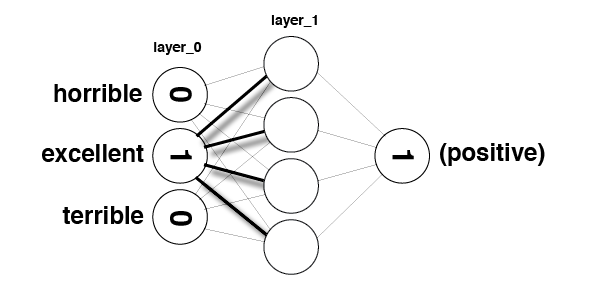

In [143]:
Image(filename='sentiment_network_sparse.png')

In [144]:
layer_0 = np.zeros(10)

In [145]:
layer_0

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [146]:
layer_0[4] = 1
layer_0[9] = 1

In [147]:
layer_0

array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.])

In [148]:
weights_0_1 = np.random.randn(10,5)

In [149]:
layer_0.dot(weights_0_1)

array([-0.10503756,  0.44222989,  0.24392938, -0.55961832,  0.21389503])

In [150]:
indices = [4,9]

In [151]:
layer_1 = np.zeros(5)

In [152]:
for index in indices:
    layer_1 += (1 * weights_0_1[index])

In [153]:
layer_1

array([-0.10503756,  0.44222989,  0.24392938, -0.55961832,  0.21389503])

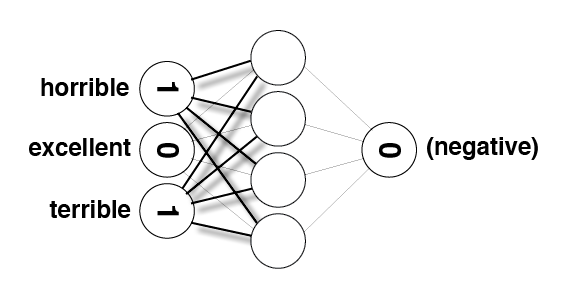

In [154]:
Image(filename='sentiment_network_sparse_2.png')

In [155]:
layer_1 = np.zeros(5)

In [156]:
for index in indices:
    layer_1 += (weights_0_1[index])

In [157]:
layer_1

array([-0.10503756,  0.44222989,  0.24392938, -0.55961832,  0.21389503])

# Project 5: Making our Network More Efficient<a id='project_5'></a>
**TODO:** Make the `SentimentNetwork` class more efficient by eliminating unnecessary multiplications and additions that occur during forward and backward propagation. To do that, you can do the following:
* Copy the `SentimentNetwork` class from the previous project into the following cell.
* Remove the `update_input_layer` function - you will not need it in this version.
* Modify `init_network`:
>* You no longer need a separate input layer, so remove any mention of `self.layer_0`
>* You will be dealing with the old hidden layer more directly, so create `self.layer_1`, a two-dimensional matrix with shape 1 x hidden_nodes, with all values initialized to zero
* Modify `train`:
>* Change the name of the input parameter `training_reviews` to `training_reviews_raw`. This will help with the next step.
>* At the beginning of the function, you'll want to preprocess your reviews to convert them to a list of indices (from `word2index`) that are actually used in the review. This is equivalent to what you saw in the video when Andrew set specific indices to 1. Your code should create a local `list` variable named `training_reviews` that should contain a `list` for each review in `training_reviews_raw`. Those lists should contain the indices for words found in the review.
>* Remove call to `update_input_layer`
>* Use `self`'s  `layer_1` instead of a local `layer_1` object.
>* In the forward pass, replace the code that updates `layer_1` with new logic that only adds the weights for the indices used in the review.
>* When updating `weights_0_1`, only update the individual weights that were used in the forward pass.
* Modify `run`:
>* Remove call to `update_input_layer` 
>* Use `self`'s  `layer_1` instead of a local `layer_1` object.
>* Much like you did in `train`, you will need to pre-process the `review` so you can work with word indices, then update `layer_1` by adding weights for the indices used in the review.

In [213]:
import time
import sys
import numpy as np

# Encapsulate our neural network in a class
class SentimentNetwork:
    def __init__(self, reviews, labels, hidden_nodes = 10, learning_rate = 0.1):
        """Create a SentimenNetwork with the given settings
        Args:
            reviews(list) - List of reviews used for training
            labels(list) - List of POSITIVE/NEGATIVE labels associated with the given reviews
            hidden_nodes(int) - Number of nodes to create in the hidden layer
            learning_rate(float) - Learning rate to use while training
        
        """
        # Assign a seed to our random number generator to ensure we get
        # reproducable results during development 
        np.random.seed(1)

        # process the reviews and their associated labels so that everything
        # is ready for training
        self.pre_process_data(reviews, labels)
        
        # Build the network to have the number of hidden nodes and the learning rate that
        # were passed into this initializer. Make the same number of input nodes as
        # there are vocabulary words and create a single output node.
        self.init_network(len(self.review_vocab),hidden_nodes, 1, learning_rate)

    def pre_process_data(self, reviews, labels):
        
        review_vocab = set()
        # TODO: populate review_vocab with all of the words in the given reviews
        #       Remember to split reviews into individual words 
        #       using "split(' ')" instead of "split()".
        for review in tqdm(reviews):
            review_vocab = review_vocab.union(set(review.split(' ')))
        
        # Convert the vocabulary set to a list so we can access words via indices
        self.review_vocab = list(review_vocab)
        
        label_vocab = set()
        # TODO: populate label_vocab with all of the words in the given labels.
        #       There is no need to split the labels because each one is a single word.
        label_vocab = label_vocab.union(set(labels))
        
        # Convert the label vocabulary set to a list so we can access labels via indices
        self.label_vocab = list(label_vocab)
        
        # Store the sizes of the review and label vocabularies.
        self.review_vocab_size = len(self.review_vocab)
        self.label_vocab_size = len(self.label_vocab)
        
        # Create a dictionary of words in the vocabulary mapped to index positions
        self.word2index = {}
        # TODO: populate self.word2index with indices for all the words in self.review_vocab
        #       like you saw earlier in the notebook
        for i, word in enumerate(self.review_vocab):
            self.word2index[word] = i
        
        # Create a dictionary of labels mapped to index positions
        self.label2index = {}
        # TODO: do the same thing you did for self.word2index and self.review_vocab, 
        #       but for self.label2index and self.label_vocab instead
        for i, label in enumerate(self.label_vocab):
            self.label2index[label] = i
        
    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Store the number of nodes in input, hidden, and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Store the learning rate
        self.learning_rate = learning_rate

        # Initialize weights
        
        # TODO: initialize self.weights_0_1 as a matrix of zeros. These are the weights between
        #       the input layer and the hidden layer.
        self.weights_0_1 = np.zeros((self.input_nodes, self.hidden_nodes))
        
        # TODO: initialize self.weights_1_2 as a matrix of random values. 
        #       These are the weights between the hidden layer and the output layer.
        self.weights_1_2 = np.random.normal(0.0, self.output_nodes**-0.5,
                                            (self.hidden_nodes, self.output_nodes))
        
        # TODO: Create the input layer, a two-dimensional matrix with shape 
        #       1 x input_nodes, with all values initialized to zero
        #self.layer_0 = np.zeros((1,input_nodes))
        self.layer_1 = np.zeros((1,hidden_nodes))
    
    def get_input_word_idxs(self, review):
        word_idx_set = set()
        
        for word in review.split(" "):
            if (word in self.word2index.keys()):
                word_idx_set.add(self.word2index[word])
                
        return list(word_idx_set)
                
    def get_target_for_label(self,label):
        # TODO: Copy the code you wrote for get_target_for_label 
        #       earlier in this notebook. 
        return 1 if (label == 'POSITIVE') else 0
        
    def sigmoid(self,x):
        # TODO: Return the result of calculating the sigmoid activation function
        #       shown in the lectures
        return 1/(1 + np.exp(-x))
    
    def sigmoid_output_2_derivative(self,output):
        # TODO: Return the derivative of the sigmoid activation function, 
        #       where "output" is the original output from the sigmoid fucntion 
        return output * (1 - output) 

    def train(self, training_reviews_raw, training_labels):
        ## New for Project 5: pre-process training reviews so we can deal 
        #                     directly with the indices of non-zero inputs
        training_reviews = []
        for x in tqdm(training_reviews_raw):
            training_reviews.append(self.get_input_word_idxs(x))  

        # make sure out we have a matching number of reviews and labels
        assert(len(training_reviews) == len(training_labels))
        
        # Keep track of correct predictions to display accuracy during training 
        correct_so_far = 0

        # Remember when we started for printing time statistics
        start = time.time()
        
        # loop through all the given reviews and run a forward and backward pass,
        # updating weights for every item
        for i in range(len(training_reviews)):
            
            # Get the next review and its correct label
            review = training_reviews[i]
            label = training_labels[i]
            
            #### Implement the forward pass here ####
            ### Forward pass ###

            ## New for Project 5: Removed call to 'update_input_layer' function
            #                     because 'layer_0' is no longer used

            # Hidden layer
            ## New for Project 5: Add in only the weights for non-zero items
            self.layer_1 *= 0
            for index in review:
                self.layer_1 += self.weights_0_1[index]

            # Output layer
            ## New for Project 5: changed to use 'self.layer_1' instead of 'local layer_1'
            layer_2 = self.sigmoid(self.layer_1.dot(self.weights_1_2))            
            
            #### Implement the backward pass here ####
            ### Backward pass ###

            # Output error
            layer_2_error = layer_2 - self.get_target_for_label(label) # Output layer error is the difference between desired target and actual output.
            layer_2_delta = layer_2_error * self.sigmoid_output_2_derivative(layer_2)

            # Backpropagated error
            layer_1_error = layer_2_delta.dot(self.weights_1_2.T) # errors propagated to the hidden layer
            layer_1_delta = layer_1_error # hidden layer gradients - no nonlinearity so it's the same as the error

            # Update the weights
            ## New for Project 5: changed to use 'self.layer_1' instead of local 'layer_1'
            self.weights_1_2 -= self.layer_1.T.dot(layer_2_delta) * self.learning_rate # update hidden-to-output weights with gradient descent step
            
            ## New for Project 5: Only update the weights that were used in the forward pass
            for index in review:
                self.weights_0_1[index] -= layer_1_delta[0] * self.learning_rate # update input-to-hidden weights with gradient descent step

            # Keep track of correct predictions.
            if(layer_2 >= 0.5 and label == 'POSITIVE'):
                correct_so_far += 1
            elif(layer_2 < 0.5 and label == 'NEGATIVE'):
                correct_so_far += 1
            
            # For debug purposes, print out our prediction accuracy and speed 
            # throughout the training process. 
            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct_so_far) + " #Trained:" + str(i+1) \
                             + " Training Accuracy:" + str(correct_so_far * 100 / float(i+1))[:4] + "%")
            if(i % 2500 == 0):
                print("")
    
    def test(self, testing_reviews, testing_labels):
        """
        Attempts to predict the labels for the given testing_reviews,
        and uses the test_labels to calculate the accuracy of those predictions.
        """
        
        # keep track of how many correct predictions we make
        correct = 0

        # we'll time how many predictions per second we make
        start = time.time()

        # Loop through each of the given reviews and call run to predict
        # its label. 
        for i in range(len(testing_reviews)):
            pred = self.run(testing_reviews[i])
            if(pred == testing_labels[i]):
                correct += 1
            
            # For debug purposes, print out our prediction accuracy and speed 
            # throughout the prediction process. 

            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(testing_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct) + " #Tested:" + str(i+1) \
                             + " Testing Accuracy:" + str(correct * 100 / float(i+1))[:4] + "%")
    
    def run(self, review):
        """
        Returns a POSITIVE or NEGATIVE prediction for the given review.
        """
        # TODO: Run a forward pass through the network, like you did in the
        #       "train" function. That means use the given review to 
        #       update the input layer, then calculate values for the hidden layer,
        #       and finally calculate the output layer.
        #
        #       Note: The review passed into this function for prediction 
        #             might come from anywhere, so you should convert it 
        #             to lower case prior to using it.
        # Input Layer
        #self.update_input_layer(review.lower())
        word_idxs = self.get_input_word_idxs(review)
        
        # Hidden layer
        #layer_1 = self.layer_0.dot(self.weights_0_1)
        self.layer_1 *= 0
        for index in word_idxs:
            self.layer_1 += self.weights_0_1[index]
        
        # Output layer
        layer_2 = self.sigmoid(self.layer_1.dot(self.weights_1_2))
        
        # TODO: The output layer should now contain a prediction. 
        #       Return `POSITIVE` for predictions greater-than-or-equal-to `0.5`, 
        #       and `NEGATIVE` otherwise.
        if(layer_2[0] >= 0.5):
            return "POSITIVE"
        else:
            return "NEGATIVE"

Run the following cell to recreate the network and train it once again.

In [204]:
mlp = SentimentNetwork(reviews[:-1000],labels[:-1000], learning_rate=0.1)
mlp.train(reviews[:-1000],labels[:-1000])


100%|██████████| 24000/24000 [00:06<00:00, 3849.18it/s]


Progress:0.0% Speed(reviews/sec):0.0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):1389. #Correct:1752 #Trained:2501 Training Accuracy:70.0%
Progress:20.8% Speed(reviews/sec):1095. #Correct:3749 #Trained:5001 Training Accuracy:74.9%
Progress:30.0% Speed(reviews/sec):1054. #Correct:5617 #Trained:7213 Training Accuracy:77.8%Progress:31.2% Speed(reviews/sec):995.8 #Correct:5855 #Trained:7501 Training Accuracy:78.0%
Progress:41.6% Speed(reviews/sec):936.1 #Correct:7992 #Trained:10001 Training Accuracy:79.9%
Progress:52.0% Speed(reviews/sec):920.4 #Correct:10121 #Trained:12501 Training Accuracy:80.9%
Progress:62.5% Speed(reviews/sec):966.9 #Correct:12253 #Trained:15001 Training Accuracy:81.6%
Progress:72.9% Speed(reviews/sec):1018. #Correct:14380 #Trained:17501 Training Accuracy:82.1%
Progress:83.3% Speed(reviews/sec):1016. #Correct:16561 #Trained:20001 Training Accuracy:82.8%
Progress:93.7% Speed(reviews/sec):1036. #Correct:18746 #Trained:22501 Training Ac

That should have trained much better than the earlier attempts. Run the following cell to test your model with 1000 predictions.

In [202]:
mlp.test(reviews[-1000:],labels[-1000:])

Progress:99.9% Speed(reviews/sec):1140. #Correct:852 #Tested:1000 Testing Accuracy:85.2%

# End of Project 5. 
## Watch the next video to see Andrew's solution, then continue on to the next lesson.
# Further Noise Reduction<a id='lesson_6'></a>

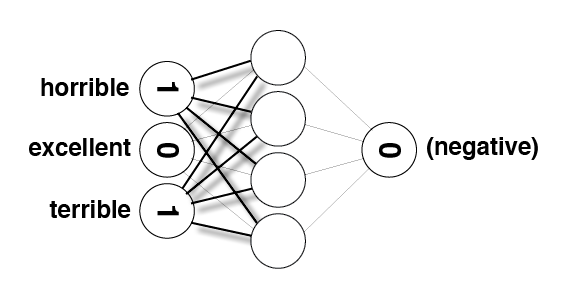

In [205]:
Image(filename='sentiment_network_sparse_2.png')

In [206]:
# words most frequently seen in a review with a "POSITIVE" label
pos_neg_ratios.most_common()

[('edie', 4.6913478822291435),
 ('paulie', 4.0775374439057197),
 ('felix', 3.1527360223636558),
 ('polanski', 2.8233610476132043),
 ('matthau', 2.8067217286092401),
 ('victoria', 2.6810215287142909),
 ('mildred', 2.6026896854443837),
 ('gandhi', 2.5389738710582761),
 ('flawless', 2.451005098112319),
 ('superbly', 2.2600254785752498),
 ('perfection', 2.1594842493533721),
 ('astaire', 2.1400661634962708),
 ('captures', 2.0386195471595809),
 ('voight', 2.0301704926730531),
 ('wonderfully', 2.0218960560332353),
 ('powell', 1.9783454248084671),
 ('brosnan', 1.9547990964725592),
 ('lily', 1.9203768470501485),
 ('bakshi', 1.9029851043382795),
 ('lincoln', 1.9014583864844796),
 ('refreshing', 1.8551812956655511),
 ('breathtaking', 1.8481124057791867),
 ('bourne', 1.8478489358790986),
 ('lemmon', 1.8458266904983307),
 ('delightful', 1.8002701588959635),
 ('flynn', 1.7996646487351682),
 ('andrews', 1.7764919970972666),
 ('homer', 1.7692866133759964),
 ('beautifully', 1.7626953362841438),
 ('socc

In [207]:
# words most frequently seen in a review with a "NEGATIVE" label
list(reversed(pos_neg_ratios.most_common()))[0:30]

[('boll', -4.9698132995760007),
 ('uwe', -4.6249728132842707),
 ('seagal', -3.6441435602725449),
 ('unwatchable', -3.2580965380214821),
 ('stinker', -3.2088254890146994),
 ('mst', -2.9502698994772336),
 ('incoherent', -2.9368917735310576),
 ('unfunny', -2.6922395950755678),
 ('waste', -2.6193845640165536),
 ('blah', -2.5704288232261625),
 ('horrid', -2.4849066497880004),
 ('pointless', -2.4553061800117097),
 ('atrocious', -2.4259083090260445),
 ('redeeming', -2.3682390632154826),
 ('prom', -2.3608540011180215),
 ('drivel', -2.3470368555648795),
 ('lousy', -2.3075726345050849),
 ('worst', -2.2869878961803778),
 ('laughable', -2.2643638801738479),
 ('awful', -2.2271942470274348),
 ('poorly', -2.2207550747464135),
 ('wasting', -2.2046046846338418),
 ('remotely', -2.1972245773362196),
 ('existent', -2.0794415416798357),
 ('boredom', -1.9951003932460849),
 ('miserably', -1.9924301646902063),
 ('sucks', -1.9870682215488209),
 ('uninspired', -1.9832976811269336),
 ('lame', -1.981767458946166)

In [208]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [209]:
hist, edges = np.histogram(list(map(lambda x:x[1],pos_neg_ratios.most_common())), density=True, bins=100, normed=True)

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="Word Positive/Negative Affinity Distribution")
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="#555555")
show(p)

In [210]:
frequency_frequency = Counter()

for word, cnt in total_counts.most_common():
    frequency_frequency[cnt] += 1

In [211]:
hist, edges = np.histogram(list(map(lambda x:x[1],frequency_frequency.most_common())), density=True, bins=100, normed=True)

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="The frequency distribution of the words in our corpus")
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="#555555")
show(p)

# Project 6: Reducing Noise by Strategically Reducing the Vocabulary<a id='project_6'></a>

**TODO:** Improve `SentimentNetwork`'s performance by reducing more noise in the vocabulary. Specifically, do the following:
* Copy the `SentimentNetwork` class from the previous project into the following cell.
* Modify `pre_process_data`:
>* Add two additional parameters: `min_count` and `polarity_cutoff`
>* Calculate the positive-to-negative ratios of words used in the reviews. (You can use code you've written elsewhere in the notebook, but we are moving it into the class like we did with other helper code earlier.)
>* Andrew's solution only calculates a postive-to-negative ratio for words that occur at least 50 times. This keeps the network from attributing too much sentiment to rarer words. You can choose to add this to your solution if you would like.  
>* Change so words are only added to the vocabulary if they occur in the vocabulary more than `min_count` times.
>* Change so words are only added to the vocabulary if the absolute value of their postive-to-negative ratio is at least `polarity_cutoff`
* Modify `__init__`:
>* Add the same two parameters (`min_count` and `polarity_cutoff`) and use them when you call `pre_process_data`

In [276]:
import time
import sys
import numpy as np
import warnings

# Encapsulate our neural network in a class
class SentimentNetwork:
    def __init__(self, reviews, labels, min_count, polarity_cutoff, 
                 hidden_nodes = 10, learning_rate = 0.1):
        """Create a SentimenNetwork with the given settings
        Args:
            reviews(list) - List of reviews used for training
            labels(list) - List of POSITIVE/NEGATIVE labels associated with the given reviews
            hidden_nodes(int) - Number of nodes to create in the hidden layer
            learning_rate(float) - Learning rate to use while training
        
        """
        # Assign a seed to our random number generator to ensure we get
        # reproducable results during development 
        np.random.seed(1)

        # process the reviews and their associated labels so that everything
        # is ready for training
        self.pre_process_data(reviews, labels, min_count, polarity_cutoff)
        
        # Build the network to have the number of hidden nodes and the learning rate that
        # were passed into this initializer. Make the same number of input nodes as
        # there are vocabulary words and create a single output node.
        self.init_network(len(self.review_vocab),hidden_nodes, 1, learning_rate)   

    def calc_pos_neg_ratios(self, reviews, labels, min_count, polarity_cutoff):
        # Create three Counter objects to store positive, negative and total counts
        positive_counts = Counter()
        negative_counts = Counter()

        for i in tqdm(range(len(labels))):
            words = reviews[i].split(' ')
            counts = Counter(words)
            if labels[i] == 'POSITIVE':
                positive_counts += counts
            else:
                negative_counts += counts      

        total_counts = positive_counts + negative_counts

        # Create Counter object to store positive/negative ratios
        pos_neg_ratios = Counter()

        # TODO: Calculate the ratios of positive and negative uses of the most common words
        #       Consider words to be "common" if they've been used at least 100 times
        for term, cnt in list(total_counts.most_common()):
            try:
                if(cnt > min_count) and positive_counts[term] > 0:
                    pos_neg_ratio = positive_counts[term] / float(negative_counts[term]+1)
                    assert(pos_neg_ratio > 0.0)
                pos_neg_ratios[term] = pos_neg_ratio
            except ZeroDivisionError:
                print("1. WARNING: divide by zero", term, cnt)            

        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            # Convert ratios to logs
            pos_neg_ratio_logs = {}
            for word,ratio in pos_neg_ratios.most_common():
                try:
                    if(ratio > 1):
                        ratio_log = np.log(ratio)
                    else:
                        ratio_log = -np.log((1 / (ratio + 0.01)))

                    if abs(ratio_log) > polarity_cutoff:
                        pos_neg_ratio_logs[word] = ratio_log    
                except Warning:
                    print("2. WARNING: divide by zero", word, ratio)

        return pos_neg_ratio_logs
        
    def pre_process_data(self, reviews, labels, min_count, polarity_cutoff):
        pos_neg_ratios = self.calc_pos_neg_ratios(reviews, labels, min_count, polarity_cutoff)

        review_vocab = set()
        # TODO: populate review_vocab with all of the words in the given reviews
        #       Remember to split reviews into individual words 
        #       using "split(' ')" instead of "split()".
        for review in tqdm(reviews):
            review_vocab = review_vocab.union(set(review.split(' ')))

        # Convert the vocabulary set to a list so we can access words via indices
        self.review_vocab = list(set(pos_neg_ratios.keys()))

        label_vocab = set()
        # TODO: populate label_vocab with all of the words in the given labels.
        #       There is no need to split the labels because each one is a single word.
        label_vocab = label_vocab.union(set(labels))

        # Convert the label vocabulary set to a list so we can access labels via indices
        self.label_vocab = list(label_vocab)
 
        # Store the sizes of the review and label vocabularies.
        self.review_vocab_size = len(self.review_vocab)
        self.label_vocab_size = len(self.label_vocab)
 
        # Create a dictionary of words in the vocabulary mapped to index positions
        self.word2index = {}
        # TODO: populate self.word2index with indices for all the words in self.review_vocab
        #       like you saw earlier in the notebook
        for i, word in enumerate(self.review_vocab):
            self.word2index[word] = i

        # Create a dictionary of labels mapped to index positions
        self.label2index = {}
        # TODO: do the same thing you did for self.word2index and self.review_vocab, 
        #       but for self.label2index and self.label_vocab instead
        for i, label in enumerate(self.label_vocab):
            self.label2index[label] = i

    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Store the number of nodes in input, hidden, and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Store the learning rate
        self.learning_rate = learning_rate

        # Initialize weights
        
        # TODO: initialize self.weights_0_1 as a matrix of zeros. These are the weights between
        #       the input layer and the hidden layer.
        self.weights_0_1 = np.zeros((self.input_nodes, self.hidden_nodes))
        
        # TODO: initialize self.weights_1_2 as a matrix of random values. 
        #       These are the weights between the hidden layer and the output layer.
        self.weights_1_2 = np.random.normal(0.0, self.output_nodes**-0.5,
                                            (self.hidden_nodes, self.output_nodes))
        
        # TODO: Create the input layer, a two-dimensional matrix with shape 
        #       1 x input_nodes, with all values initialized to zero
        #self.layer_0 = np.zeros((1,input_nodes))
        self.layer_1 = np.zeros((1,hidden_nodes))
    
    def get_input_word_idxs(self, review):
        word_idx_set = set()
        
        for word in review.split(" "):
            if (word in self.word2index.keys()):
                word_idx_set.add(self.word2index[word])
                
        return list(word_idx_set)
                
    def get_target_for_label(self,label):
        # TODO: Copy the code you wrote for get_target_for_label 
        #       earlier in this notebook. 
        return 1 if (label == 'POSITIVE') else 0
        
    def sigmoid(self,x):
        # TODO: Return the result of calculating the sigmoid activation function
        #       shown in the lectures
        return 1/(1 + np.exp(-x))
    
    def sigmoid_output_2_derivative(self,output):
        # TODO: Return the derivative of the sigmoid activation function, 
        #       where "output" is the original output from the sigmoid fucntion 
        return output * (1 - output) 

    def train(self, training_reviews_raw, training_labels):
        ## New for Project 5: pre-process training reviews so we can deal 
        #                     directly with the indices of non-zero inputs
        training_reviews = []
        for x in tqdm(training_reviews_raw):
            training_reviews.append(self.get_input_word_idxs(x))  

        # make sure out we have a matching number of reviews and labels
        assert(len(training_reviews) == len(training_labels))
        
        # Keep track of correct predictions to display accuracy during training 
        correct_so_far = 0

        # Remember when we started for printing time statistics
        start = time.time()
        
        # loop through all the given reviews and run a forward and backward pass,
        # updating weights for every item
        for i in range(len(training_reviews)):
            
            # Get the next review and its correct label
            review = training_reviews[i]
            label = training_labels[i]
            
            #### Implement the forward pass here ####
            ### Forward pass ###

            ## New for Project 5: Removed call to 'update_input_layer' function
            #                     because 'layer_0' is no longer used

            # Hidden layer
            ## New for Project 5: Add in only the weights for non-zero items
            self.layer_1 *= 0
            for index in review:
                self.layer_1 += self.weights_0_1[index]

            # Output layer
            ## New for Project 5: changed to use 'self.layer_1' instead of 'local layer_1'
            layer_2 = self.sigmoid(self.layer_1.dot(self.weights_1_2))            
            
            #### Implement the backward pass here ####
            ### Backward pass ###

            # Output error
            layer_2_error = layer_2 - self.get_target_for_label(label) # Output layer error is the difference between desired target and actual output.
            layer_2_delta = layer_2_error * self.sigmoid_output_2_derivative(layer_2)

            # Backpropagated error
            layer_1_error = layer_2_delta.dot(self.weights_1_2.T) # errors propagated to the hidden layer
            layer_1_delta = layer_1_error # hidden layer gradients - no nonlinearity so it's the same as the error

            # Update the weights
            ## New for Project 5: changed to use 'self.layer_1' instead of local 'layer_1'
            self.weights_1_2 -= self.layer_1.T.dot(layer_2_delta) * self.learning_rate # update hidden-to-output weights with gradient descent step
            
            ## New for Project 5: Only update the weights that were used in the forward pass
            for index in review:
                self.weights_0_1[index] -= layer_1_delta[0] * self.learning_rate # update input-to-hidden weights with gradient descent step

            # Keep track of correct predictions.
            if(layer_2 >= 0.5 and label == 'POSITIVE'):
                correct_so_far += 1
            elif(layer_2 < 0.5 and label == 'NEGATIVE'):
                correct_so_far += 1
            
            # For debug purposes, print out our prediction accuracy and speed 
            # throughout the training process. 
            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct_so_far) + " #Trained:" + str(i+1) \
                             + " Training Accuracy:" + str(correct_so_far * 100 / float(i+1))[:4] + "%")
            if(i % 2500 == 0):
                print("")
    
    def test(self, testing_reviews, testing_labels):
        """
        Attempts to predict the labels for the given testing_reviews,
        and uses the test_labels to calculate the accuracy of those predictions.
        """
        
        # keep track of how many correct predictions we make
        correct = 0

        # we'll time how many predictions per second we make
        start = time.time()

        # Loop through each of the given reviews and call run to predict
        # its label. 
        for i in range(len(testing_reviews)):
            pred = self.run(testing_reviews[i])
            if(pred == testing_labels[i]):
                correct += 1
            
            # For debug purposes, print out our prediction accuracy and speed 
            # throughout the prediction process. 

            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(testing_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct) + " #Tested:" + str(i+1) \
                             + " Testing Accuracy:" + str(correct * 100 / float(i+1))[:4] + "%")
    
    def run(self, review):
        """
        Returns a POSITIVE or NEGATIVE prediction for the given review.
        """
        # TODO: Run a forward pass through the network, like you did in the
        #       "train" function. That means use the given review to 
        #       update the input layer, then calculate values for the hidden layer,
        #       and finally calculate the output layer.
        #
        #       Note: The review passed into this function for prediction 
        #             might come from anywhere, so you should convert it 
        #             to lower case prior to using it.
        # Input Layer
        #self.update_input_layer(review.lower())
        word_idxs = self.get_input_word_idxs(review)
        
        # Hidden layer
        #layer_1 = self.layer_0.dot(self.weights_0_1)
        self.layer_1 *= 0
        for index in word_idxs:
            self.layer_1 += self.weights_0_1[index]
        
        # Output layer
        layer_2 = self.sigmoid(self.layer_1.dot(self.weights_1_2))
        
        # TODO: The output layer should now contain a prediction. 
        #       Return `POSITIVE` for predictions greater-than-or-equal-to `0.5`, 
        #       and `NEGATIVE` otherwise.
        if(layer_2[0] >= 0.5):
            return "POSITIVE"
        else:
            return "NEGATIVE"

Run the following cell to train your network with a small polarity cutoff.

In [277]:
mlp = SentimentNetwork(reviews[:-1000],labels[:-1000],min_count=25,polarity_cutoff=0.35,learning_rate=0.01)
mlp.train(reviews[:-1000],labels[:-1000])

100%|██████████| 24000/24000 [00:05<00:00, 4142.44it/s]


Progress:0.0% Speed(reviews/sec):0.0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):1675. #Correct:2124 #Trained:2501 Training Accuracy:84.9%
Progress:20.8% Speed(reviews/sec):1785. #Correct:4290 #Trained:5001 Training Accuracy:85.7%
Progress:31.2% Speed(reviews/sec):1965. #Correct:6465 #Trained:7501 Training Accuracy:86.1%
Progress:41.6% Speed(reviews/sec):1916. #Correct:8642 #Trained:10001 Training Accuracy:86.4%
Progress:52.0% Speed(reviews/sec):2011. #Correct:10840 #Trained:12501 Training Accuracy:86.7%
Progress:62.5% Speed(reviews/sec):2089. #Correct:13034 #Trained:15001 Training Accuracy:86.8%
Progress:72.9% Speed(reviews/sec):2138. #Correct:15209 #Trained:17501 Training Accuracy:86.9%
Progress:83.3% Speed(reviews/sec):2103. #Correct:17408 #Trained:20001 Training Accuracy:87.0%
Progress:93.7% Speed(reviews/sec):2073. #Correct:19613 #Trained:22501 Training Accuracy:87.1%
Progress:99.9% Speed(reviews/sec):2082. #Correct:20942 #Trained:24000 Training

And run the following cell to test it's performance. It should be 

In [278]:
mlp.test(reviews[-1000:],labels[-1000:])

Progress:48.8% Speed(reviews/sec):2335. #Correct:429 #Tested:489 Testing Accuracy:87.7%

Progress:85.4% Speed(reviews/sec):2185. #Correct:717 #Tested:855 Testing Accuracy:83.8%

Progress:99.9% Speed(reviews/sec):2206. #Correct:842 #Tested:1000 Testing Accuracy:84.2%

Run the following cell to train your network with a much larger polarity cutoff.

In [279]:
mlp = SentimentNetwork(reviews[:-1000],labels[:-1000],min_count=20,polarity_cutoff=0.8,learning_rate=0.01)
mlp.train(reviews[:-1000],labels[:-1000])

100%|██████████| 24000/24000 [00:02<00:00, 8537.89it/s]


Progress:0.0% Speed(reviews/sec):0.0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):3896. #Correct:2131 #Trained:2501 Training Accuracy:85.2%
Progress:20.8% Speed(reviews/sec):4062. #Correct:4259 #Trained:5001 Training Accuracy:85.1%
Progress:31.2% Speed(reviews/sec):4394. #Correct:6391 #Trained:7501 Training Accuracy:85.2%
Progress:41.6% Speed(reviews/sec):4181. #Correct:8538 #Trained:10001 Training Accuracy:85.3%
Progress:52.0% Speed(reviews/sec):4247. #Correct:10677 #Trained:12501 Training Accuracy:85.4%
Progress:62.5% Speed(reviews/sec):4288. #Correct:12839 #Trained:15001 Training Accuracy:85.5%
Progress:72.9% Speed(reviews/sec):4319. #Correct:14959 #Trained:17501 Training Accuracy:85.4%
Progress:83.3% Speed(reviews/sec):4281. #Correct:17141 #Trained:20001 Training Accuracy:85.7%
Progress:93.7% Speed(reviews/sec):4343. #Correct:19331 #Trained:22501 Training Accuracy:85.9%
Progress:99.9% Speed(reviews/sec):4312. #Correct:20636 #Trained:24000 Training

And run the following cell to test it's performance.

In [280]:
mlp.test(reviews[-1000:],labels[-1000:])

Progress:33.5% Speed(reviews/sec):2497. #Correct:295 #Tested:336 Testing Accuracy:87.7%

Progress:99.9% Speed(reviews/sec):2225. #Correct:823 #Tested:1000 Testing Accuracy:82.3%

# End of Project 6. 
## Watch the next video to see Andrew's solution, then continue on to the next lesson.

# Analysis: What's Going on in the Weights?<a id='lesson_7'></a>

In [266]:
mlp_full = SentimentNetwork(reviews[:-1000],labels[:-1000],min_count=0,polarity_cutoff=0,learning_rate=0.01)

100%|██████████| 24000/24000 [02:15<00:00, 176.72it/s]


In [267]:
mlp_full.train(reviews[:-1000],labels[:-1000])

100%|██████████| 24000/24000 [00:07<00:00, 3206.25it/s]


Progress:0.0% Speed(reviews/sec):0.0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):846.8 #Correct:1956 #Trained:2501 Training Accuracy:78.2%
Progress:20.8% Speed(reviews/sec):819.5 #Correct:4003 #Trained:5001 Training Accuracy:80.0%
Progress:31.2% Speed(reviews/sec):811.3 #Correct:6122 #Trained:7501 Training Accuracy:81.6%
Progress:36.8% Speed(reviews/sec):807.6 #Correct:7276 #Trained:8851 Training Accuracy:82.2%Progress:41.6% Speed(reviews/sec):803.6 #Correct:8276 #Trained:10001 Training Accuracy:82.7%
Progress:52.0% Speed(reviews/sec):817.1 #Correct:10436 #Trained:12501 Training Accuracy:83.4%
Progress:62.5% Speed(reviews/sec):831.9 #Correct:12576 #Trained:15001 Training Accuracy:83.8%
Progress:72.9% Speed(reviews/sec):854.5 #Correct:14679 #Trained:17501 Training Accuracy:83.8%
Progress:83.3% Speed(reviews/sec):862.5 #Correct:16841 #Trained:20001 Training Accuracy:84.2%
Progress:93.7% Speed(reviews/sec):862.2 #Correct:19018 #Trained:22501 Training Ac

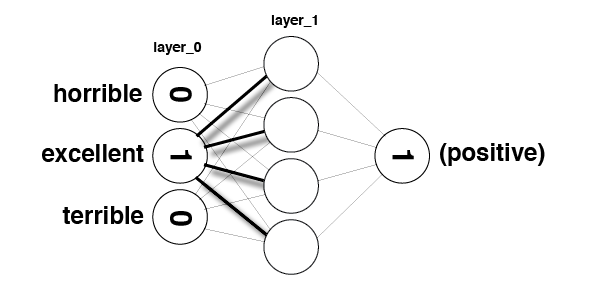

In [268]:
Image(filename='sentiment_network_sparse.png')

In [269]:
def get_most_similar_words(focus = "horrible"):
    most_similar = Counter()

    for word in mlp_full.word2index.keys():
        most_similar[word] = np.dot(mlp_full.weights_0_1[mlp_full.word2index[word]],mlp_full.weights_0_1[mlp_full.word2index[focus]])
    
    return most_similar.most_common()

In [270]:
get_most_similar_words("excellent")

[('excellent', 0.13541514678902217),
 ('perfect', 0.12407697041902102),
 ('amazing', 0.090615014306305405),
 ('today', 0.090180085711866212),
 ('wonderful', 0.08798443592836025),
 ('fun', 0.087277521674855335),
 ('best', 0.085272109033682986),
 ('great', 0.085122610009066346),
 ('liked', 0.077556492047860748),
 ('definitely', 0.077137950989843287),
 ('loved', 0.07383679104312893),
 ('brilliant', 0.073503451460977198),
 ('favorite', 0.073497353524974066),
 ('superb', 0.071435246819087417),
 ('fantastic', 0.070544866197379291),
 ('job', 0.068592820815139843),
 ('enjoyable', 0.065798002417733009),
 ('incredible', 0.06528797254403855),
 ('rare', 0.064862388880336214),
 ('highly', 0.062904933258973034),
 ('enjoyed', 0.062167131322381539),
 ('perfectly', 0.061856371628073767),
 ('wonderfully', 0.061849325676638672),
 ('bit', 0.059596172365445003),
 ('fascinating', 0.059502279124792903),
 ('gem', 0.059204863953423899),
 ('outstanding', 0.058702006420622302),
 ('beautiful', 0.05842213832442842

In [271]:
get_most_similar_words("terrible")

[('worst', 0.17078853474419026),
 ('awful', 0.12199329703289058),
 ('waste', 0.12052430806695),
 ('poor', 0.093187487750670331),
 ('terrible', 0.093031709566802318),
 ('dull', 0.085722810795655247),
 ('poorly', 0.081577214104632312),
 ('disappointment', 0.080896955521070957),
 ('fails', 0.079277292632623494),
 ('boring', 0.078792061333570904),
 ('disappointing', 0.076784482000832072),
 ('unfortunately', 0.076170097934940756),
 ('mess', 0.071722806275891754),
 ('worse', 0.070824268121130282),
 ('stupid', 0.069073922559805601),
 ('badly', 0.067330048565408002),
 ('annoying', 0.066714113452228607),
 ('bad', 0.064972768113635448),
 ('save', 0.063906617188686621),
 ('wasted', 0.062306050422599998),
 ('disappointed', 0.062047298236964303),
 ('supposed', 0.061076647150378818),
 ('horrible', 0.059850657441341513),
 ('laughable', 0.059606775242690216),
 ('crap', 0.057715531040859691),
 ('basically', 0.057105971896452321),
 ('ridiculous', 0.056954436838470679),
 ('avoid', 0.056836193868842755),


In [272]:
import matplotlib.colors as colors

words_to_visualize = list()
for word, ratio in pos_neg_ratios.most_common(500):
    if(word in mlp_full.word2index.keys()):
        words_to_visualize.append(word)
    
for word, ratio in list(reversed(pos_neg_ratios.most_common()))[0:500]:
    if(word in mlp_full.word2index.keys()):
        words_to_visualize.append(word)

In [273]:
pos = 0
neg = 0

colors_list = list()
vectors_list = list()
for word in words_to_visualize:
    if word in pos_neg_ratios.keys():
        vectors_list.append(mlp_full.weights_0_1[mlp_full.word2index[word]])
        if(pos_neg_ratios[word] > 0):
            pos+=1
            colors_list.append("#00ff00")
        else:
            neg+=1
            colors_list.append("#000000")

In [274]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
words_top_ted_tsne = tsne.fit_transform(vectors_list)

In [275]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="vector T-SNE for most polarized words")

source = ColumnDataSource(data=dict(x1=words_top_ted_tsne[:,0],
                                    x2=words_top_ted_tsne[:,1],
                                    names=words_to_visualize,
                                    color=colors_list))

p.scatter(x="x1", y="x2", size=8, source=source, fill_color="color")

word_labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(word_labels)

show(p)

# green indicates positive words, black indicates negative words